## Identify Board Space

https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_corner.html#sphx-glr-auto-examples-features-detection-plot-corner-py

### Detect Edges

In [57]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi

from skimage import io
from skimage import feature
from skimage.color import rgb2gray
from skimage.transform import resize

def get_image(resize_img=True, grayscale_img=True):
    img_paths = [x for x in Path('img').iterdir()]
    image = io.imread(str(img_paths[2]))
    
    if resize_img:
        image = resize(
            image, 
            (image.shape[0] / 4, image.shape[1] / 4),
            anti_aliasing=True
        )
    
    if grayscale_img:
        image = rgb2gray(image)
    
    return image

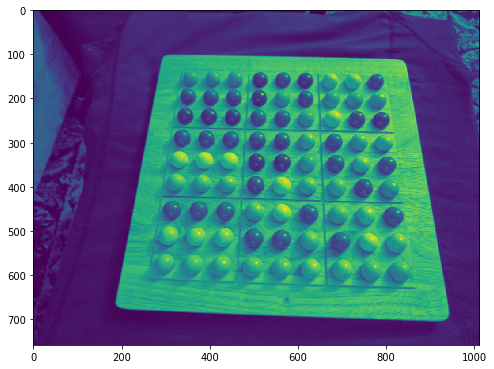

In [58]:
image = get_image()
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image);

In [42]:
# Compute the Canny filter for several values of sigma
edges = []
for sigma in [x/10 for x in range(11)]:
    edges.append(feature.canny(image, sigma=sigma))

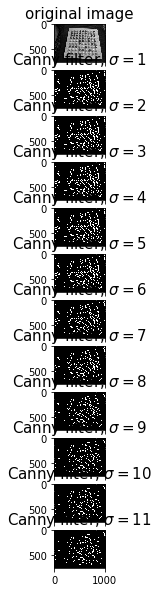

In [43]:
# display results
fig, axes = plt.subplots(nrows=len(edges)+1, ncols=1, figsize=(10, 10),
                         sharex=True, sharey=True)

axes[0].imshow(image, cmap=plt.cm.gray)
axes[0].set_title('original image', fontsize=15)

i = 0
for ax, edge in zip(axes[1:], edges):
    i += 1
    ax.imshow(edge, cmap=plt.cm.gray)
    ax.set_title(f'Canny filter, $\sigma={i}$', fontsize=15)

# fig.tight_layout()

plt.show();

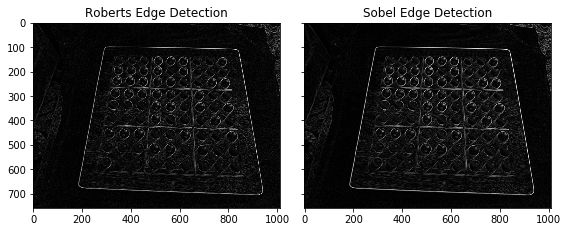

In [35]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.filters import roberts, sobel, scharr, prewitt


edge_roberts = roberts(image)
edge_sobel = sobel(image)

fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True,
                       figsize=(8, 4))

ax[0].imshow(edge_roberts, cmap=plt.cm.gray)
ax[0].set_title('Roberts Edge Detection')

ax[1].imshow(edge_sobel, cmap=plt.cm.gray)
ax[1].set_title('Sobel Edge Detection')

plt.tight_layout()
plt.show()

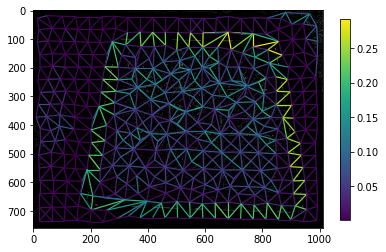

In [51]:
from skimage.future import graph
from skimage import data, segmentation, color, filters, io
from matplotlib import pyplot as plt


img = get_image()
gimg = color.rgb2gray(img)

labels = segmentation.slic(img, compactness=30, n_segments=400)
edges = filters.sobel(gimg)
edges_rgb = color.gray2rgb(edges)

g = graph.rag_boundary(labels, edges)
lc = graph.show_rag(labels, g, edges_rgb, img_cmap=None, edge_cmap='viridis',
                    edge_width=1.2)

plt.colorbar(lc, fraction=0.03)
io.show()

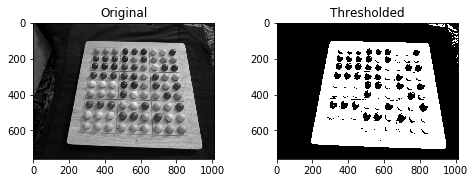

In [60]:
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu


image = get_image(grayscale_img=True)
thresh = threshold_otsu(image)
binary = image > thresh

fig, axes = plt.subplots(ncols=2, figsize=(8, 2.5))

axes[0].imshow(image, cmap=plt.cm.gray)
axes[0].set_title('Original')

axes[1].imshow(binary, cmap=plt.cm.gray)
axes[1].set_title('Thresholded')

plt.show()

https://stackoverflow.com/questions/11602259/find-the-smallest-containing-convex-polygon-with-a-given-number-of-points
https://www.researchgate.net/publication/226436325_Minimum_area_circumscribing_Polygons

In [157]:
from skimage.feature import canny
from scipy import ndimage as ndi
from skimage import morphology
from skimage.filters import threshold_otsu


image = get_image(grayscale_img=True)

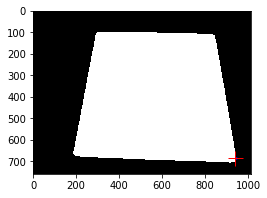

In [188]:
thresh = threshold_otsu(image)
binary = image > thresh

edges = canny(binary)
filled = ndi.binary_fill_holes(edges)
cleaned = morphology.remove_small_objects(
    filled, image.shape[0] * image.shape[1] / 2 # must be large than 1/4 of the image
)

coords = corner_peaks(
    corner_harris(cleaned, k=0.05), 
    min_distance=10,
    min_distance=1,
    threshold_abs=None,
    threshold_rel=0.1,
    exclude_border=True,
    indices=True,
    num_peaks=inf,
    footprint=None,
    labels=None)
coords_subpix = corner_subpix(cleaned, coords, window_size=13)

fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(coords[:, 1], coords[:, 0], '.b', markersize=3)
ax.plot(coords_subpix[:, 1], coords_subpix[:, 0], '+r', markersize=15)
ax.imshow(cleaned, cmap=plt.cm.gray);

In [189]:
corner_peaks?

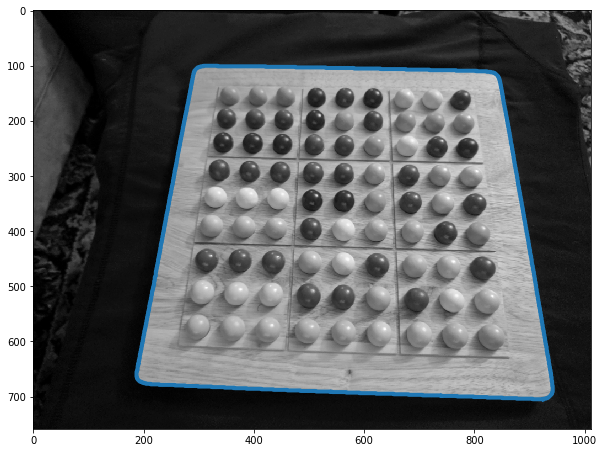

In [160]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import measure
from skimage.filters import threshold_otsu


def bbox_area(points):
    """X: 2D array"""
    if len(points.shape) != 2 or points.shape[1] != 2:
        raise ValueError(
            f"Points must be a (n,2), array but it has shape {points.shape}"
        )
    if points.shape[0] < 1:
        raise ValueError("Can't compute bounding box for empty coordinates")
    minx, miny = np.min(points, axis=0)
    maxx, maxy = np.max(points, axis=0)

    return (maxx - minx) * (maxy - miny)

image = get_image(grayscale_img=True)

thresh = threshold_otsu(image)
binary = image > thresh

# Find contours at a constant value of 0.1
contours = measure.find_contours(binary, 0.1)
contour = max(contours, key=bbox_area)

# Display the image and plot largest contour bounding box
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(img, interpolation='nearest', cmap=plt.cm.gray)
ax.plot(contour[:, 1], contour[:, 0], linewidth=4)

plt.show()

In [187]:
approximate_polygon?

(2727, 2) (6, 2)


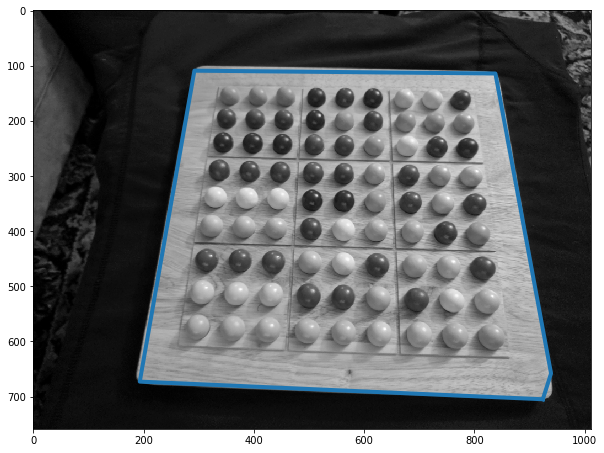

In [186]:
from skimage.measure import approximate_polygon, subdivide_polygon

appr_contour = approximate_polygon(contour, tolerance=20)

print(contour.shape, appr_contour.shape)

# Display the image and plot largest contour bounding box
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(img, interpolation='nearest', cmap=plt.cm.gray)
ax.plot(appr_contour[:, 1], appr_contour[:, 0], linewidth=4)

plt.show()

### Identify Corners

In [84]:
from pathlib import Path

from matplotlib import pyplot as plt

from skimage.feature import corner_harris, corner_subpix, corner_peaks

image = get_image()

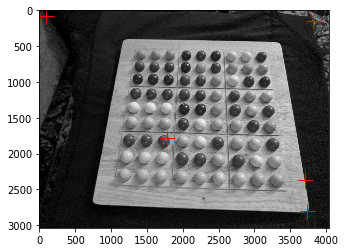

In [28]:
coords = corner_peaks(corner_harris(image), min_distance=5)
coords_subpix = corner_subpix(image, coords, window_size=13)

fig, ax = plt.subplots()
ax.imshow(image, interpolation='nearest', cmap=plt.cm.gray)
# ax.plot(coords[:, 1], coords[:, 0], '.b', markersize=3)
ax.plot(coords_subpix[:, 1], coords_subpix[:, 0], '+r', markersize=15)
plt.show()

## Rectify Board Space

https://scikit-image.org/docs/stable/auto_examples/applications/plot_geometric.html#sphx-glr-auto-examples-applications-plot-geometric-py

TODO: automate identification of board corners

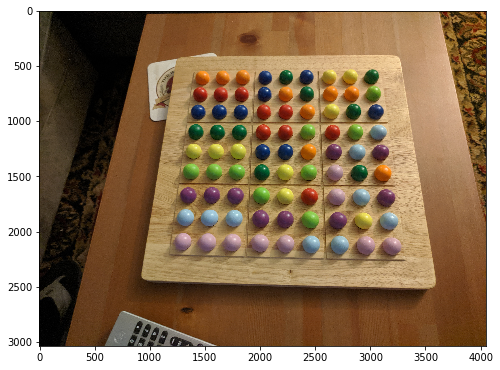

In [57]:
from pathlib import Path

import math
import numpy as np
import matplotlib.pyplot as plt

from skimage import io
from skimage import data
from skimage import transform as tf

img_paths = [x for x in Path('img').iterdir()]
board = io.imread(str(img_paths[0]))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(board);

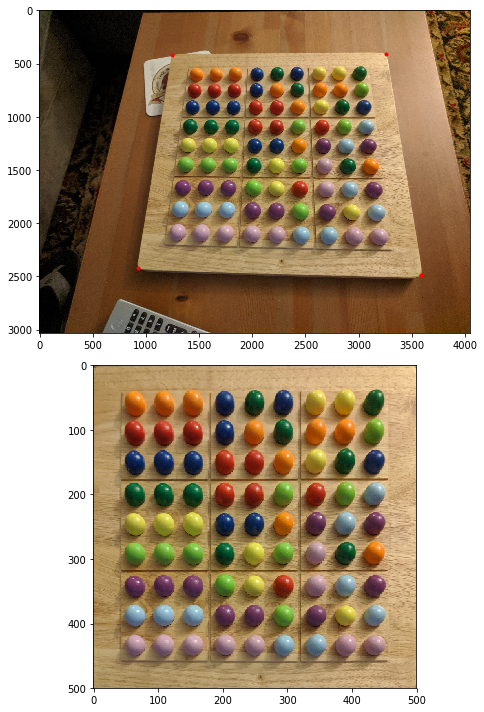

In [58]:
# top left, bottom left, bottom right, top right
src = np.array([[0, 0], [0, 500], [500, 500], [500, 0]])
# TODO: automate the identification of these corners:
dst = np.array([
    [1250,   420], [930,  2420],  # x, y left edge
    [3590,  2490], [3260,  410],   # x, y right edge
])

tform3 = tf.ProjectiveTransform()
tform3.estimate(src, dst)
warped = tf.warp(board, tform3, output_shape=(500, 500))

fig, ax = plt.subplots(nrows=2, figsize=(10, 10))

ax[0].imshow(board, cmap=plt.cm.gray)
ax[0].plot(dst[:, 0], dst[:, 1], '.r')
ax[1].imshow(warped, cmap=plt.cm.gray)

plt.tight_layout()

plt.show()